In [1]:
%matplotlib inline
import sys
import os
import csv
import numpy as np
import pandas as pd
sys.path.append("/Users/edwardlrichards/compAcoustics") 
import makeEnv
import matplotlib.pylab as plt
from normalMode import Chinook
from wni import Corgi

In [2]:
# SwellEx enviornmental data
ctdNumber = 5
frequency = 49
falseBottomWidth = 300
decimation = 10
zSource_deep = 50
zSource_shallow = 3

In [3]:
# Water column
rho_w = 1000
atten_w = 0
z_bot = 216.5
# Read CTD data
ctdPath = "/Users/edwardlrichards/ctds"
ctdPrefix = "i96"
ctdSuffix = ".prn"
ctdName = os.path.join(ctdPath, ctdPrefix + '{0:02d}'.format(ctdNumber) + ctdSuffix)
ctd = pd.read_csv(ctdName, sep='\s+',\
                  names = ['temperature [C]', 'salinity [PSU]',\
                           'sound speed [m/sec]', 'sigma-t'])
lastValue = ctd.tail(1)
lastValue.index = [z_bot]
ctd = ctd.append(lastValue)

In [4]:
# Sediment 1
cTop = 1572.3
cBot = 1593
rho_b1 = 1760
atten_b1 = 0.2  # dB/kmHz
zBot = 23.5
z_b1 = np.r_[0:zBot:5j]
c_b1 = (z_b1 * (cBot - cTop) / np.max(z_b1)) + cTop

In [5]:
# Sediment 2
cTop = 1881
cBot = 3245
rho_b2 = 2060
atten_b2 = 0.06
zBot = 800
z_b2 = np.r_[0:zBot:5j]
c_b2 = (z_b1 * (cBot - cTop) / np.max(z_b2)) + cTop

In [6]:
# Basement
rho_b = 2.66
atten_b = 0.02
c_b = 5200

In [7]:
# sortof a random atten conversion
c = 1500
f = 100
l = c / f
conversion = c / 1000
atten_w *= conversion
atten_b1 *= conversion
atten_b2 *= conversion
atten_b *= conversion

In [8]:
# Save layers
ssp = ctd['sound speed [m/sec]']
layer_w = (np.array(ssp.index), ssp.values, rho_w, atten_w)
layer_b1 = (np.max(layer_w[0]) + z_b1, c_b1, rho_b1, atten_b1)
layer_b2 = (np.max(layer_b1[0]) + z_b2, c_b2, rho_b2, atten_b2)
layer_b = (np.max(layer_b2[0]), c_b, rho_b, atten_b)

profile = [layer_w, layer_b1, layer_b2, layer_b]
enviornment = makeEnv.acousticEnv()
enviornment.addProfile(profile, 0)

In [9]:
# Normal mode propagation
nm_model = Chinook(frequency, enviornment)
nm_model.calculateModes_eig(falseBottomWidth, decimation)

In [10]:
zRange = np.r_[0:200:100j]
rRange = np.r_[10:10000:200j]

In [11]:
wni_model = Corgi(enviornment, zSource_deep, frequency, zRange,\
                   np.max(rRange))
wni_model.integrateSpectrum()
p_wni_deep = wni_model.getPressure()

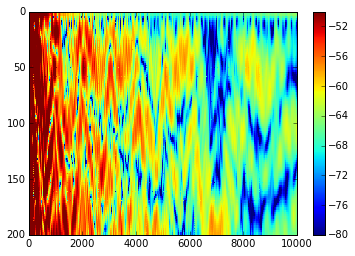

In [12]:
# Transmission loss plot
TL_wni = 20 * np.log10(np.abs(np.array(p_wni_deep) + np.spacing(1)))
r_wni = p_wni_deep.index
Z, R = np.meshgrid(zRange, r_wni)
plt.pcolormesh(R.T, Z.T, np.array(TL_wni).T)

_ = plt.clim(-80, -50)
_ = plt.xlim(0, 10000)
_ = plt.ylim(200,0)
_ = plt.colorbar()

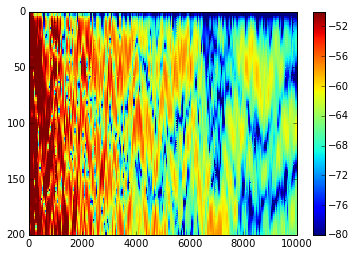

In [13]:
# Transmission loss plot
TL_nm = nm_model.calculatePressure(zSource_deep, zRange, rRange)
TL_nm = 20 * np.log10(np.abs(TL_nm + np.spacing(1)))
Z, R = np.meshgrid(zRange, rRange)
_ = plt.pcolormesh(R.T, Z.T, np.array(TL_nm).T)
_ = plt.ylim(200, 0)
plt.clim(-80, -50)
_ = plt.colorbar()

In [14]:
R.shape

(200, 100)

In [15]:
TL_nm.shape

(200, 100)

TypeError: unhashable type: 'slice'

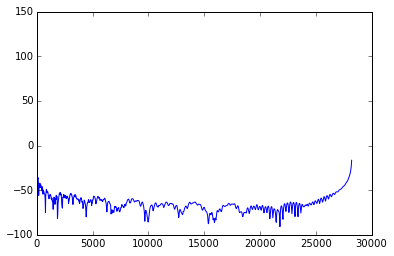

In [16]:
# Transmission loss plot
zI = 30
_ = plt.plot(p_wni_deep.index, TL_wni[:, zI], label='wni')
_ = plt.plot(rRange, TL_nm[zI,:], label='nm')
_ = plt.xlim(0, max(rRange))
_ = plt.ylim(-80, -30)
_ = plt.legend()

In [ ]:
# Compute pressure at bottom two recievers
zReceivers = [210.25, 212.25]
# zReceivers = [210.62, 212.25]

deepPressure = nm_model.calculatePressure(zSource_deep,\
                                          zReceivers, r)
p = np.sum(deepPressure, axis = 0) / 2
v = np.squeeze(np.diff(deepPressure, axis = 0))
w = np.vstack((p,v))
w_d = w / p

shallowPressure = nm_model.calculatePressure(zSource_shallow,\
                                             zReceivers, r)
p = np.sum(shallowPressure, axis = 0) / 2
v = np.squeeze(np.diff(shallowPressure, axis = 0))
w = np.vstack((p,v))
w_s = w / p

In [ ]:
# Broadband run
f_broad = np.array([49, 64, 79, 94, 112, 130, 148,\
                    166, 201, 235, 283, 338, 388], dtype = float)

theta_broad_deep = []
theta_broad_shallow = []

for freq in f_broad:
    nm_model = Chinook(freq, enviornment)
    nm_model.calculateModes_eig(falseBottomWidth, decimation)
    pressure = nm_model.calculatePressure(zSource_deep,\
                                            zReceivers, r)
    # Deep source
    p = np.sum(pressure, axis = 0) / 2
    v = np.squeeze(np.diff(pressure, axis = 0))
    theta_broad_deep.append(np.degrees(np.arccos(np.real(v / p))))
    
    # Shallow source
    pressure = nm_model.calculatePressure(zSource_shallow,\
                                          zReceivers, r)
    p = np.sum(pressure, axis = 0) / 2
    v = np.squeeze(np.diff(pressure, axis = 0))
    theta_broad_shallow.append(np.degrees(np.arccos(np.real(v / p))))

In [ ]:
for i in range(3):
    _ = plt.plot(r, theta_broad_deep[i],\
             label = str(f_broad[i]) + ' Hz source')

_ = plt.xlim(1000, 10000)
_ = plt.ylim(86, 96)
_ = plt.title(r'NM: Deep source, $\theta$ for all source ranges')
_ = plt.legend(loc=4)
_ = plt.xlabel('range, m')
_ = plt.ylabel(r'$\theta$')
plt.savefig('/Users/edwardlrichards/swellEx/vectorSensor/multiFreq')

In [ ]:
# Comparison of deep and shallow source
fI = 4
_ = plt.plot(r, theta_broad_deep[fI],\
             label = str(zSource_deep) + ' m source')
_ = plt.plot(r, theta_broad_shallow[fI],\
             label = str(zSource_shallow) + ' m source')
_ = plt.title(r'NM: ' + str(f_broad[fI]) +\
              r' Hz source, $\theta$ for all source ranges')
_ = plt.xlabel('range, m')
_ = plt.ylabel(r'$\theta$')
_ = plt.legend(loc = 4)
# _ = plt.ylim(84, 96)
plt.savefig('/Users/edwardlrichards/swellEx/vectorSensor/theta_' +\
           str(fI))

In [ ]:
# Comparison of deep and shallow source
fI = 0
_ = plt.plot(r, theta_broad_deep[fI],\
             label = str(zSource_deep) + ' m source')
_ = plt.plot(r, theta_broad_shallow[fI],\
             label = str(zSource_shallow) + ' m source')
_ = plt.title(r'NM: ' + str(f_broad[fI]) +\
              r' Hz source, $\theta$ for all source ranges')
_ = plt.xlabel('range, m')
_ = plt.ylabel(r'$\theta$')
_ = plt.legend(loc = 4)
# _ = plt.ylim(90, 93)
# plt.savefig('/Users/edwardlrichards/swellEx/vectorSensor/theta_' +\
#            str(fI) + '_zoom')

In [ ]:
wni_model = Corgi(enviornment, zSource_deep, frequency, zReceivers,\
                   np.max(r))
wni_model.integrateSpectrum()
p_wni_deep = wni_model.getPressure()

p = np.sum(p_wni_deep.T, axis = 0) / 2
v = np.squeeze(np.diff(p_wni_deep.T, axis = 0))
w = np.vstack((p,v))
w_wni_d = w / p[None,:]

wni_model = Corgi(enviornment, zSource_shallow, frequency, zReceivers,\
                   np.max(r))
wni_model.integrateSpectrum()
p_wni_shallow = wni_model.getPressure()

p = np.sum(p_wni_shallow.T, axis = 0) / 2
v = np.squeeze(np.diff(p_wni_shallow.T, axis = 0))
w = np.vstack((p,v))
w_wni_s = w / p[None,:]

In [ ]:
zI = 0
zComp = zReceivers[zI]

_ = plt.plot(p_wni_deep.index, np.arccos(np.real(w_wni_d[1])),\
             label = str(zSource_deep) + ' source')
_ = plt.plot(p_wni_deep.index, np.arccos(np.real(w_wni_s[1])),\
             label = str(zSource_shallow) + ' source')
_ = plt.title('WNI: v_z for all source ranges')
_ = plt.xlabel('range, m')
_ = plt.ylabel('v_z')
_ = plt.legend()
_ = plt.xlim(0, max(r))
# _ = plt.ylim(-1.5, 1.5)